In [2]:
import scvi
import scanpy as sc
import numpy as np

Global seed set to 0


In [9]:
pbmc3k = scvi.data.read_h5ad("/home/fengling/Documents/nnbatch/data/tutorial/pbmc3k_raw.h5ad")

In [10]:
pbmc5k = sc.read_10x_h5(
    "/home/fengling/Documents/nnbatch/data/tutorial/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5",
    gex_only=False
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
pbmc5k.var_names_make_unique()

In [12]:
pbmc5k.var.feature_types.astype("category").cat.categories

Index(['Antibody Capture', 'Gene Expression'], dtype='object')

In [13]:
scvi.data.organize_cite_seq_10x(pbmc5k)

In [ ]:
adata = pbmc5k.concatenate(pbmc3k)

In [19]:
adata

AnnData object with n_obs × n_vars = 7947 × 20453
    obs: 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'gene_ids-1'
    uns: '_scvi'

In [20]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

In [21]:
adata.layers["counts"] = adata.X.copy()

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [23]:
adata.raw = adata

In [17]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 7947 cells, 14309 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [18]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [19]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 7/400:   2%|      | 6/400 [00:28<31:35,  4.81s/it, loss=4.24e+03, v_num=1]

/home/fengling/software/pkg/mamba/envs/nnbatch-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [ ]:
vae.save("/home/fengling/Documents/nnbatch/data/tutorial/vae_model/")

In [24]:
vae = scvi.model.SCVI.load("/home/fengling/Documents/nnbatch/data/tutorial/vae_model_2", adata)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              


/home/fengling/software/pkg/mamba/envs/nnbatch-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 7947 cells, 14309 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [25]:
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb, latent_distribution: normal
Training status: Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [27]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [29]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

/home/fengling/software/pkg/mamba/envs/nnbatch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types-0' as categorical
/home/fengling/software/pkg/mamba/envs/nnbatch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome-0' as categorical


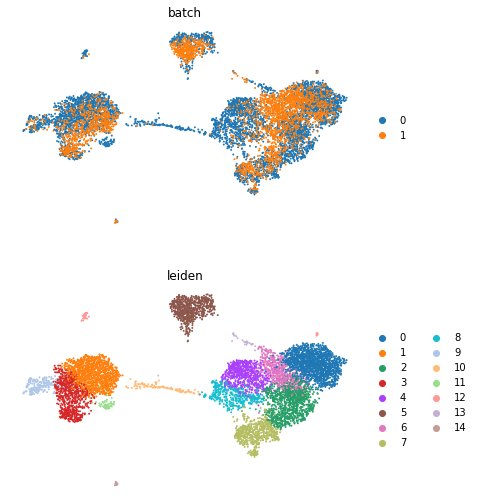

In [30]:
sc.pl.umap(
    adata,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

In [32]:
sc.tl.pca(adata, svd_solver='arpack', n_comps = 50)
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3, maxiter = 250)

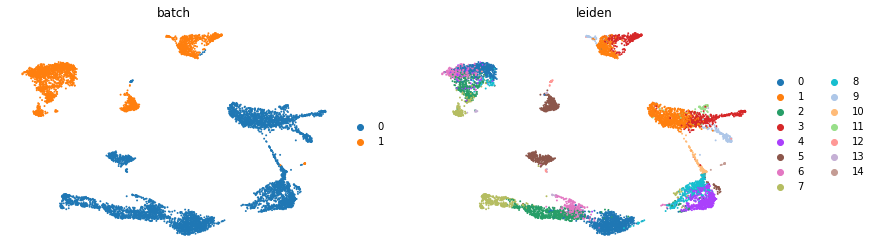

In [34]:
sc.pl.umap(
    adata,
    color=["batch", "leiden"],
    frameon=False,
)

In [35]:
adata

AnnData object with n_obs × n_vars = 7947 × 14309
    obs: 'batch', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'gene_ids-1', 'n_counts'
    uns: '_scvi', 'log1p', 'neighbors', 'leiden', 'umap', 'batch_colors', 'leiden_colors', 'pca'
    obsm: 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'